<a href="https://colab.research.google.com/github/ELBrown11/StarbucksCapstoneChallenge/blob/main/Starbucks_Capstone_Heuristics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
import gc

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

ValueError: mount failed

In [ ]:
demo_data = pd.read_csv('/content/drive/MyDrive/Udacity DS Nanodegree/Capstone Project/df_demographics.csv', low_memory=False)

In [ ]:
demo_data

,user_id,event,offer_type,gender,age_group,income_bracket,membership_length_wks
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,bogo,F,75-84,100k+,<1
1,a03223e636434f42ac4c3df47e8bac43,offer received,discount,NaN,NaN,<65k,<1
2,e2127556f4f64592b11af22de27a7932,offer received,discount,M,65-74,65-100k,<1
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,discount,NaN,NaN,<65k,<1
4,68617ca6246f4fbc85e91a2a49552598,offer received,bogo,NaN,NaN,<65k,<1
...,...,...,...,...,...,...,...
167576,a6f84f4e976f44508c358cc9aba6d2b3,offer completed,discount,NaN,NaN,<65k,NaN
167577,b895c57e8cd047a8872ce02aa54759d6,offer completed,discount,NaN,NaN,<65k,NaN
167578,8dda575c2a1d44b9ac8e8b07b93d1f8e,offer viewed,discount,F,55-64,<65k,NaN
167579,8431c16f8e1d440880db371a68f82dd0,offer completed,discount,M,35-44,<65k,NaN


In [ ]:
demo_data['offer_type'].value_counts()

,count
offer_type,
bogo,71617
discount,69898
informational,26066


- can see significant missing data within some of the demographc columns.

In [ ]:
demo_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167581 entries, 0 to 167580
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   user_id                167581 non-null  object
 1   event                  167581 non-null  object
 2   offer_type             167581 non-null  object
 3   gender                 148805 non-null  object
 4   age_group              148754 non-null  object
 5   income_bracket         167581 non-null  object
 6   membership_length_wks  154435 non-null  object
dtypes: object(7)
memory usage: 8.9+ MB


In [ ]:
#define demo columns
demo_cols = ['gender', 'age_group', 'income_bracket', 'membership_length_wks']

In [ ]:
def clean_data(df, segment_cols):
    """
    Cleans and preprocesses offer interaction data for segmentation analysis.

    Parameters:
    - df (pd.DataFrame): Raw offer data with events, segment info, and offer types.
    - segment_cols (list): List of segmentation columns (e.g., ['gender', 'age_group']).


    Returns:
    - pd.DataFrame: Cleaned DataFrame ready for grouping and analysis.
    """

    # 1. Drop rows with missing segmentation data
    df_clean = df.dropna(subset=segment_cols).copy()


    return df_clean
demo_data = clean_data(demo_data, demo_cols)

In [ ]:
demo_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 136722 entries, 0 to 154434
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   user_id                136722 non-null  object
 1   event                  136722 non-null  object
 2   offer_type             136722 non-null  object
 3   gender                 136722 non-null  object
 4   age_group              136722 non-null  object
 5   income_bracket         136722 non-null  object
 6   membership_length_wks  136722 non-null  object
dtypes: object(7)
memory usage: 8.3+ MB


In [ ]:
demo_data.columns

Index(['user_id', 'event', 'offer_type', 'gender', 'age_group',
       'income_bracket', 'membership_length_wks'],
      dtype='object')

In [ ]:
demo_cols = ['gender', 'age_group', 'income_bracket', 'membership_length_wks']

### **Flexible Completion Rate**
* completion = receieved  ➡ completed (doesn't require viewing)

In [ ]:
def get_offer_response_summary(df, segment_cols):
    """
    Calculates view and completion rates for each offer type within each demographic segment.
    Filters out rows with missing or zero completion rates.

    Parameters:
    - df (pd.DataFrame): DataFrame containing at least ['user_id', 'event', 'offer_type'] + segment_cols
    - segment_cols (list): List of demographic columns to use for segmentation.

    Returns:
    - pd.DataFrame: Summary of offer performance by segment, with view and completion rates.
    """

    # Step 1: Filter only offer-related events
    offer_df = df[df['event'].isin([
        'offer received', 'offer viewed', 'offer completed'
    ])].copy()

    # Step 2: Keep only necessary columns
    keep_cols = ['user_id', 'event', 'offer_type'] + segment_cols
    offer_df = offer_df[keep_cols].copy()

    # Step 3: Create binary event flags
    offer_df['received'] = (offer_df['event'] == 'offer received').astype(int)
    offer_df['viewed'] = (offer_df['event'] == 'offer viewed').astype(int)
    offer_df['completed'] = (offer_df['event'] == 'offer completed').astype(int)

    # Step 4: Aggregate by user + offer_type + segment
    group_cols = ['user_id', 'offer_type'] + segment_cols
    user_offer_summary = offer_df.groupby(group_cols, observed=False).agg(
        received=('received', 'max'),
        viewed=('viewed', 'max'),
        completed=('completed', 'max')
    ).reset_index()

    # Step 5: Keep only users who received the offer
    user_offer_summary = user_offer_summary[user_offer_summary['received'] == 1].copy()

    # Step 6: Aggregate by offer type and segment
    segment_group_cols = ['offer_type'] + segment_cols
    summary = user_offer_summary.groupby(segment_group_cols, observed=False).agg(
        Received=('received', 'count'),
        Viewed=('viewed', 'sum'),
        Completed=('completed', 'sum')
    ).reset_index()

    # Step 7: Calculate response rates
    summary['Viewed Rate (%)'] = np.where(
        summary['Received'] > 0,
        (summary['Viewed'] / summary['Received'] * 100).round(1),
        np.nan
    )
    summary['Completion Rate (%)'] = np.where(
        summary['Received'] > 0,
        (summary['Completed'] / summary['Received'] * 100).round(1),
        np.nan
    )

    # Step 8: Remove rows where Completion Rate is missing or 0
    summary = summary[
        (summary['Completion Rate (%)'].notna()) &
        (summary['Completion Rate (%)'] > 0)
    ].copy()

    # Step 9: Rename for readability
    summary = summary.rename(columns={
        'offer_type': 'Offer type'
    })

    # Step 10: Clean up memory
    del offer_df, user_offer_summary
    gc.collect()

    return summary

new_df = get_offer_response_summary(demo_data, demo_cols)
new_df

,Offer type,gender,age_group,income_bracket,membership_length_wks,Received,Viewed,Completed,Viewed Rate (%),Completion Rate (%)
0,bogo,F,18-24,65-100k,1,12,10,7,83.3,58.3
1,bogo,F,18-24,65-100k,2,21,14,11,66.7,52.4
2,bogo,F,18-24,65-100k,3+,11,6,7,54.5,63.6
3,bogo,F,18-24,65-100k,<1,15,10,8,66.7,53.3
4,bogo,F,18-24,<65k,1,46,33,17,71.7,37.0
...,...,...,...,...,...,...,...,...,...,...
460,discount,O,75-84,<65k,<1,5,4,2,80.0,40.0
461,discount,O,85+,65-100k,1,1,1,1,100.0,100.0
462,discount,O,85+,65-100k,2,3,3,3,100.0,100.0
465,discount,O,85+,<65k,3+,1,1,1,100.0,100.0


### **Strict Completions Rate**
* completion  = viewed ➡ recieved ➡ completed

In [ ]:
def get_strict_offer_response_summary(df, segment_cols):
    """
    Calculates strict view and completion rates for each offer type within each demographic segment.
    Only counts a completion if the offer was also viewed.

    Parameters:
    - df (pd.DataFrame): DataFrame containing at least ['user_id', 'event', 'offer_type'] + segment_cols
    - segment_cols (list): List of demographic columns to use for segmentation.

    Returns:
    - pd.DataFrame: Summary of offer performance by segment, with strict view and completion rates.
    """
    # Step 1: Filter only offer-related events
    offer_df = df[df['event'].isin([
        'offer received', 'offer viewed', 'offer completed'
    ])].copy()

    # Step 2: Keep only necessary columns
    keep_cols = ['user_id', 'event', 'offer_type'] + segment_cols
    offer_df = offer_df[keep_cols].copy()

    # Step 3: Create binary flags for each event
    offer_df['received'] = (offer_df['event'] == 'offer received').astype(int)
    offer_df['viewed'] = (offer_df['event'] == 'offer viewed').astype(int)
    offer_df['completed'] = (offer_df['event'] == 'offer completed').astype(int)

    # Step 4: Aggregate by user + offer_type + segment
    group_cols = ['user_id', 'offer_type'] + segment_cols
    user_offer_summary = offer_df.groupby(group_cols, observed=False).agg(
        received=('received', 'max'),
        viewed=('viewed', 'max'),
        completed=('completed', 'max')
    ).reset_index()

    # Step 5: Only keep users who received the offer
    user_offer_summary = user_offer_summary[user_offer_summary['received'] == 1].copy()

    # Step 6: Add a 'strictly_completed' flag = 1 only if viewed and completed
    user_offer_summary['strictly_completed'] = (
        (user_offer_summary['viewed'] == 1) &
        (user_offer_summary['completed'] == 1)
    ).astype(int)

    # Step 7: Aggregate by segment
    segment_group_cols = ['offer_type'] + segment_cols
    summary = user_offer_summary.groupby(segment_group_cols, observed=False).agg(
        Received=('received', 'count'),
        Viewed=('viewed', 'sum'),
        Strictly_Completed=('strictly_completed', 'sum')
    ).reset_index()

    # Step 8: Compute rates
    summary['Viewed Rate (%)'] = np.where(
        summary['Received'] > 0,
        (summary['Viewed'] / summary['Received'] * 100).round(1),
        np.nan
    )
    summary['Strict Completion Rate (%)'] = np.where(
        summary['Received'] > 0,
        (summary['Strictly_Completed'] / summary['Received'] * 100).round(1),
        np.nan
    )

    # Step 9: Filter out empty results
    summary = summary[
        (summary['Strict Completion Rate (%)'].notna()) &
        (summary['Strict Completion Rate (%)'] > 0)
    ].copy()

    # Step 10: Rename for readability
    summary = summary.rename(columns={
        'offer_type': 'Offer type'
    })

    return summary


# **Data Visualization and Analysis**

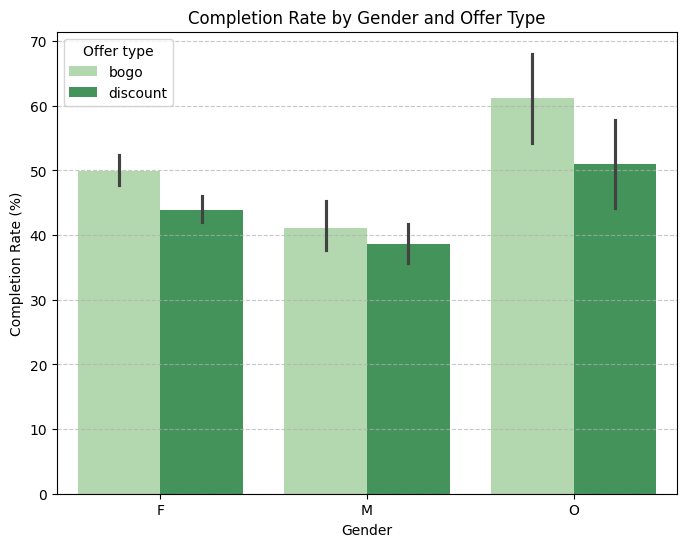

In [ ]:
#vfisualize completion rate by gender
plt.figure(figsize=(8, 6))
sns.barplot(data=new_df, x='gender', y='Completion Rate (%)', hue='Offer type', palette='Greens')
plt.title('Completion Rate by Gender and Offer Type')
plt.xlabel('Gender')
plt.ylabel('Completion Rate (%)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

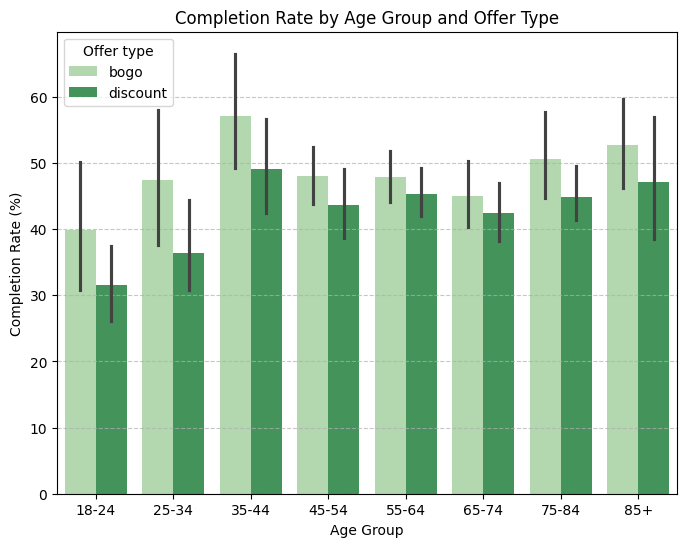

In [ ]:
# Plotting Completion Rate by Gender
plt.figure(figsize=(8, 6))
sns.barplot(data=new_df, x='age_group', y='Completion Rate (%)', hue='Offer type', palette='Greens')
plt.title('Completion Rate by Age Group and Offer Type')
plt.xlabel('Age Group')
plt.ylabel('Completion Rate (%)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

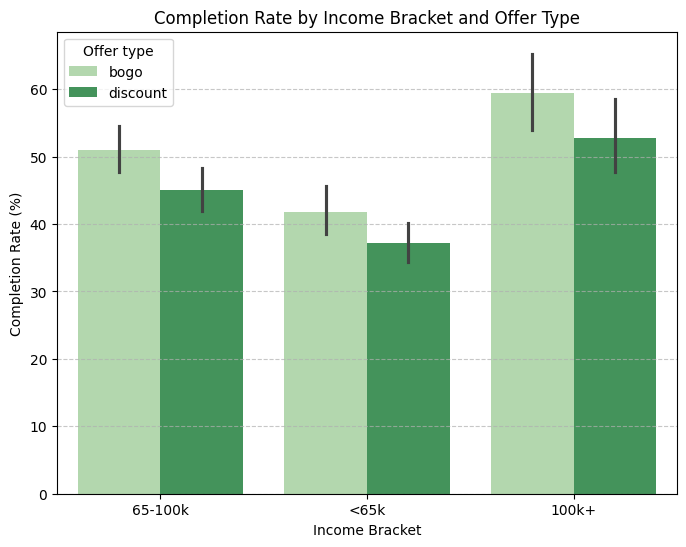

In [ ]:
plt.figure(figsize=(8, 6))
sns.barplot(data=new_df, x='income_bracket', y='Completion Rate (%)', hue='Offer type', palette='Greens')
plt.title('Completion Rate by Income Bracket and Offer Type')
plt.xlabel('Income Bracket')
plt.ylabel('Completion Rate (%)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

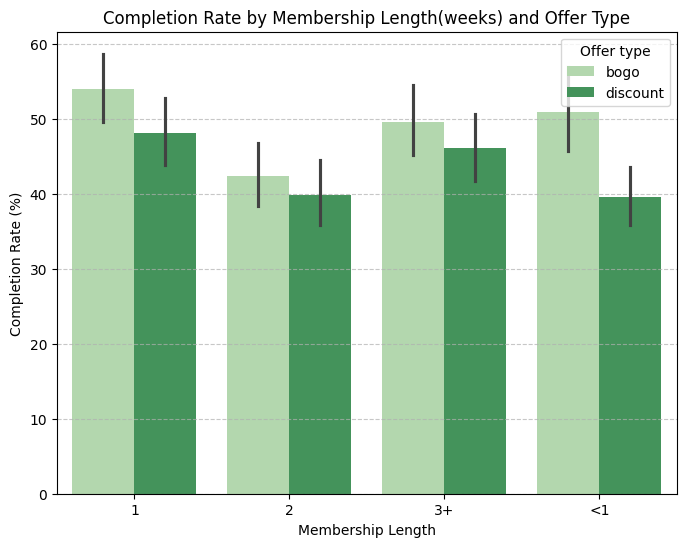

In [ ]:
plt.figure(figsize=(8, 6))
sns.barplot(data=new_df, x='membership_length_wks', y='Completion Rate (%)', hue='Offer type', palette='Greens')

plt.title('Completion Rate by Membership Length(weeks) and Offer Type')
plt.xlabel('Membership Length')
plt.ylabel('Completion Rate (%)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Offer type with the greatest average completion rate: bogo (49.1%)


/tmp/ipython-input-17-3630439982.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=offer_completion_summary, x='Offer type', y='Completion Rate (%)', palette='Greeens')


ValueError: 'Greeens' is not a valid palette name

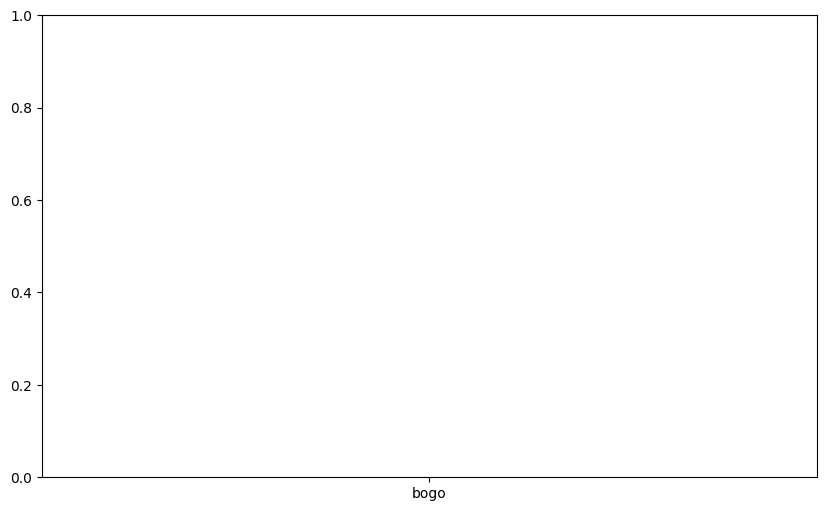

In [ ]:
# prompt: data viz that shows offer type with greatest completion rate over all

# Aggregate completion rates by offer type across all segments
offer_completion_summary = new_df.groupby('Offer type')['Completion Rate (%)'].mean().reset_index()

# Find the offer type with the highest average completion rate
best_offer_type = offer_completion_summary.sort_values(by='Completion Rate (%)', ascending=False).iloc[0]

print(f"Offer type with the greatest average completion rate: {best_offer_type['Offer type']} ({best_offer_type['Completion Rate (%)']:.1f}%)")

# Visualize the average completion rate by offer type
plt.figure(figsize=(10, 6))
sns.barplot(data=offer_completion_summary, x='Offer type', y='Completion Rate (%)', palette='Greeens')
plt.title('Average Completion Rate by Offer Type (Across all Segments)')
plt.xlabel('Offer Type')
plt.ylabel('Average Completion Rate (%)')
plt.ylim(0, 100) # Set y-axis limit to 0-100 for percentage
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show();

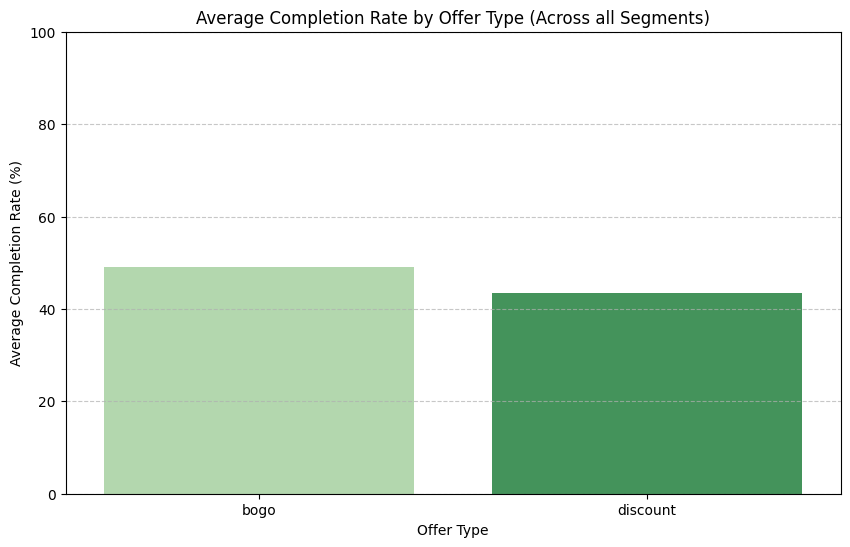

In [ ]:
plt.figure(figsize=(10, 6))

sns.barplot(
    data=offer_completion_summary,
    x='Offer type',
    y='Completion Rate (%)',
    hue='Offer type',
    palette=sns.color_palette("Greens", n_colors=len(offer_completion_summary)),
    legend=False  # Optional: hides legend if you don't need it
)

plt.title('Average Completion Rate by Offer Type (Across all Segments)')
plt.xlabel('Offer Type')
plt.ylabel('Average Completion Rate (%)')
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show();


- originally there were 4 offer types
  - tranasaction meant that there was no offer
  - informational is an offer that cannot be completed bc it is just information
  - conclusion: bogo and discount are the only other offer types

In [ ]:
new_df.describe()

In [ ]:
print(f"Average completion rate:  {round(new_df['Completion Rate (%)'].mean(),2)}%")
print(f"Average viewership rate:  {round(new_df['Viewed Rate (%)'].mean(),2)}%")

In [ ]:
print(f"Median completion rate:  {new_df['Completion Rate (%)'].median()}%")
print(f"Median viewership rate:  {new_df['Viewed Rate (%)'].median()}%")

# **Develop Heuristics**
- group the data by demographic segments
- find top performing offers
- create a look up table that contains rules
    
         eg. for segment x, recommend offer y

In [ ]:
def get_best_offers_by_segment(summary_df, metric='Completion Rate (%)'):
    """
    Returns the best-performing offer type for each segment based on a performance metric.

    Parameters:
    - summary_df (pd.DataFrame): Offer response summary (output of get_offer_response_summary).
    - metric (str): Column to use for ranking offer performance ('Completion Rate (%)' or 'Viewed Rate (%)').

    Returns:
    - pd.DataFrame: One row per segment, with the best offer type and its performance.
    """
    segment_cols = [col for col in summary_df.columns if col not in [
        'Offer type', 'Received', 'Viewed', 'Completed', 'Viewed Rate (%)', 'Completion Rate (%)'
    ]]

    # Sort to keep best offer per segment
    best_offers = (
        summary_df.sort_values(by=segment_cols + [metric], ascending=[True]*len(segment_cols) + [False])
        .groupby(segment_cols, observed=False)
        .first()
        .reset_index()
    )

    return best_offers
best_offers = get_best_offers_by_segment(new_df, 'Completion Rate (%)')
best_offers

In [ ]:
best_offers.describe()

In [ ]:
for _, row in best_offers.iterrows():
    rule = (
        f"IF gender == '{row['gender']}' AND "
        f"age_group == '{row['age_group']}' AND "
        f"income_bracket == '{row['income_bracket']}' AND "
        f"membership_length_wks == '{row['membership_length_wks']}' "
        f"THEN send offer: {row['Offer type']}"
    )
    print(rule)

In [ ]:
# prompt: from rule create dataframe with columns gender, age_group, income_bracket, membership_length_wks and offer_type

# Convert the rules into a DataFrame
rules_list = []
for _, row in best_offers.iterrows():
    rules_list.append({
        'gender': row['gender'],
        'age_group': row['age_group'],
        'income_bracket': row['income_bracket'],
        'membership_length_wks': row['membership_length_wks'],
        'offer_type': row['Offer type']
    })

rules_df = pd.DataFrame(rules_list)
rules_df

In [ ]:
def recommend_offer(user_profile, rules_df, default_offer='informational'):
    """
    Recommends best offer based on user profile which consists of demographic info.

    Parameters:
    - user_profile (dict): User demographic information (e.g., {'gender': 'M', 'age_group': '26-3
    5', 'income_bracket': '7
    - rules_df (pd.DataFrame): DataFrame containing heuristic rules for offers
    - default_offer (str): Offer to recommend if no rules match.

    Returns:
    - str: Recommended offer type.
    """
    match = rules_df[
        (rules_df['gender'] == user_profile['gender']) &
        (rules_df['age_group'] == user_profile['age_group']) &
        (rules_df['income_bracket'] == user_profile['income_bracket']) &
        (rules_df['membership_length_wks'] == user_profile['membership_length_wks'])
    ]

    if not match.empty:
        return match.iloc[0]['offer_type']
    else:
        return default_offer
